In [5]:
!pip install --upgrade pip
!pip install torch torchmetrics lightning robust_downloader prettytable matplotlib jupyter_black

In [6]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import jupyter_black

jupyter_black.load()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Image Classification - A Practical Approach

## Learning Goals

- Learn how to model an image classification task
- Learn how to systematically implement data prep, model architecture, training-loop, and evaluation
- Learn how to check and verify the implementation
- Learn how to incorporate boilerplate code from [torchvision](https://pytorch.org/vision/0.9/index.html) and  [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/)

## Setup

Let's define paths, install & load the necessary Python packages.

Mount your google drive to store data and results (if running the code in Google Colab).

In [7]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [8]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

**Modify the following paths if necessary.**

That is where your data will be stored.

In [9]:
from pathlib import Path
import os

if IN_COLAB:
    pass  # TODO DATA_PATH = Path("/content/drive/MyDrive/cas-dl-module-compvis-part1")
else:
    SCRIPT_DIR = Path(os.getcwd())
    DATA_PATH = SCRIPT_DIR / "data/data_set/three_classes"

Install `dl_cv_lectures`

In [10]:
try:
    import dl_cv_lectures

    print("dl_cv_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install -e .")
    else:
        print("Installing from git repo")
        os.system(
            "pip install git+https://github.com/marco-willi/cas-dl-compvis-exercises-hs2024"
        )

dl_cv_lectures installed, all good


Load all packages

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torchshow as ts
from lightning.pytorch.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import make_grid

import dl_cv_lectures

In [12]:
DEBUG = False

## 2) Overall Approach

Inspired by [A Recipe for Training Neural Networks by Andrej Karpathy](https://karpathy.github.io/2019/04/25/recipe/)

For your chosen dataset. Do the following:


### 1) Data Preparation & Data Inspection

- Download the data
- Inspect the data formats
- Build a `torch.utils.data.Dataset`
    - define training, validation and test sets
- Implement a `torch.utils.data.DataLoader'
- Inspect the data:
    - Look at samples
    - Inspect the label distribution

### 2) Baselines

- Implement a small CNN
- Learn input-independent baseline (provide only labels but random noise as input)
- Overfitt CNN on one batch
- Inspect pre-processing
  
### 3) (Over)fit
- Build a large(er) architecture (pre-trained or self-implemented)
- Train a high-performing model with respect to training set
  
### 4) Regularize
- Is it beneficial to collect more data?
- Data Augmentation
- Early Stopping on Validation Set
- Weight Decay

### 5) Hyper-Parameter Tuning
- Define HPs and parameterise architecture
- do grid- or random search over HP grids

### 6) Squeeze out the juice
-  Ensembling
-  Longer training
-  Special techniques: AdamW optimizer, fancy data augmentation, label smoothing, stochastic depth

## Step 1) - Data Preparation & Data Inspection

**_This step is critical. I like to spend copious amount of time (measured in units of hours) scanning through thousands of examples, understanding their distribution and looking for patterns. (A Karpathy)_**

- Download the data
- Inspect the data formats and file organization
- Remove corrupt data
- Build a [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
    - define training, validation and test sets
- Implement a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
- Inspect the data:
    - Look at samples
    - Inspect the label distribution


Important information about how to define a dataset can be found here: [https://pytorch.org/docs/stable/data.htm](https://pytorch.org/docs/stable/data.htm)

### Download the Data

Specify the dataset that you want to use and download it (unless you are using your own - in that case place it in your data directory).

Download and extraction may take a few minutes.

In [13]:
DATA_BASE_DIR = SCRIPT_DIR / "data"

In [14]:
from robust_downloader import download


def download_and_unpack(url, filename, data_dir):
    data_download_dir = Path(data_dir) / "download"
    data_download_dir.mkdir(parents=True, exist_ok=True)
    data_archive = data_download_dir / filename
    if not data_archive.exists():
        download(url, data_download_dir, filename)
    data_set_dir = data_dir / "data_set"
    if not data_set_dir.exists():
        data_set_dir.mkdir(parents=True, exist_ok=True)
        print(data_archive)
        with zipfile.ZipFile(data_archive, "r") as zipf:
            zipf.extractall(data_set_dir)
    return data_set_dir


url = "https://mostwiedzy.pl/en/open-research-data/lego-bricks-for-training-classification-network,202309140842198941751-0/download/"
filename = "file 05 - dataset.zip"
data_set_dir = download_and_unpack(url, filename, DATA_BASE_DIR)

In [15]:
from pathlib import Path
from typing import Callable

import lightning as L
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset


class LegoBricksData(L.LightningDataModule):
    """Create a data module to manage train, validation and test sets."""

    def __init__(
        self,
        train_observations: list[dict],
        val_observations: list[dict],
        test_observations: list[dict],
        classes: list[str],
        train_transform: Callable,
        test_transform: Callable,
        batch_size: int = 32,
        num_workers: int = 4,
    ):
        super().__init__()
        self.classes = classes
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_observations = train_observations
        self.val_observations = val_observations
        self.test_observations = test_observations

        self.train_transform = train_transform
        self.test_transform = test_transform

    def setup(self, stage=None):
        """Split the dataset into train, validation, and test sets."""
        if stage == "fit" or stage is None:
            self.ds_train = LegoBricks(
                self.train_observations,
                transform=self.train_transform,
                classes=self.classes,
            )
            self.ds_val = LegoBricks(
                self.val_observations,
                transform=self.test_transform,
                classes=self.classes,
            )

        if stage == "test" or stage is None:
            self.ds_test = LegoBricks(
                self.test_observations,
                transform=self.test_transform,
                classes=self.classes,
            )

    def train_dataloader(self):
        """Return the train data loader."""
        return DataLoader(
            self.ds_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        """Return the validation data loader."""
        return DataLoader(
            self.ds_val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        """Return the test data loader."""
        return DataLoader(
            self.ds_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

## Inspect Data Format & Organization

We need to figure out how the data is organized. Particularly, how the data is labelled, to correctly define it with a [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

First you should look at the data / folder structure of the downloaded data.

(this example command only works on Linux)


In [16]:
!find "{DATA_PATH}" -type d

/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/3941
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2412b
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357


It seems the data is neatly organized in class-specific folders.

In [17]:
!find "{DATA_PATH}/2357" -type f | head -n 10

/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357/c3_7_IfZU_original-Bs5_1620809597653.jpg
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357/c4_8_HKP7_original-Bs5_1620809623802.jpg
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357/c0_5_n3fc_original-Bs5_1620809560833.jpg
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357/c2_7_IfZU_original-Bs5_1620809597653.jpg
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357/c1_5_n3fc_original-Bs5_1620809560833.jpg
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set/three_classes/2357/c5_8_HKP7_original-Bs5_1620809623802.jpg
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_proj

Seems like we have ".jpg" files. This needs to be verified further.

**Note**: You might want to check for corrupt files since they disrupt further processes. You could read each file using `PIL.Image.open` to find any errors.

We use a function to provide an inventory of all the files, along with their labels.

Change the path accordingly if you used a different dataset.

In [18]:
from utils import ImageFolder

Now we create the dataset object and inspect the first observation.

Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images


['Brick 2 x 2 Corner',
 'Brick Round 2 x 2 with Axle Hole',
 'Tile Special 1 x 2 Grille with Bottom Groove']

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=539x538>,
 'label': 1}

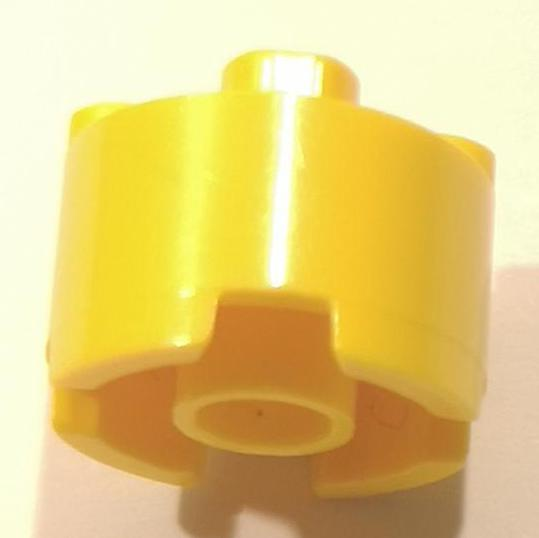

In [19]:
ds = ImageFolder(DATA_PATH)
ds.classes
ds[200]
ds[200]["image"]

## Create Train / Test Splits

We create train (validation) and test splits early, before we look at the data in more detail. This avoids any biases and insights that we might clean from the test set. We should set this part of the data aside and look at it only for a final model evaluation.

We use a function from `sklearn.model_selection`.

We balance the labels by using the `stratify` option.

**Note**: Some datasets may have a pre-defined split. If so, the images might be in separate test/train folders. If that is the case simply create different dataset objects.

In [20]:
from sklearn.model_selection import train_test_split

all_ids = [i for i in range(0, len(ds.observations))]
all_labels = [x["label"] for x in ds.observations]

train_ids, test_ids = train_test_split(
    all_ids,
    stratify=all_labels,
    test_size=0.2,
    random_state=123,
)

train_ids, val_ids = train_test_split(
    train_ids,
    stratify=[all_labels[i] for i in train_ids],
    test_size=0.1,
    random_state=123,
)


ds_train = ImageFolder.from_subset(ds, train_ids)
ds_val = ImageFolder.from_subset(ds, val_ids)
ds_test = ImageFolder.from_subset(ds, test_ids)

Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 553 images from the original dataset of 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 62 images from the original dataset of 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 154 images from the original dataset of 769 images


Now we test the `Dataset` object by getting and visualising a sample.

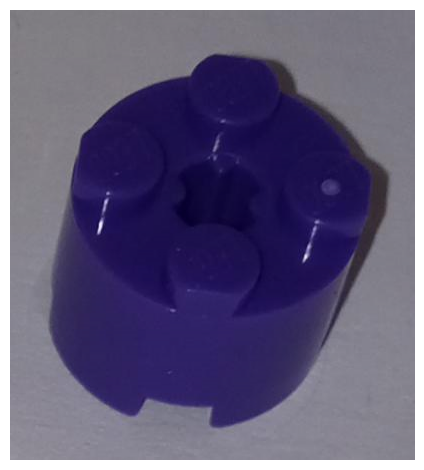

In [21]:
observation = ds_train[0]
ts.show(observation["image"])

## Create Data Loaders

For model training we need to batch examples. Thats why we need to define a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Let's see how our data is being batched, after all each observation is a dictionary.

In [22]:
tr_train = transforms.Compose(
    [transforms.v2.RGB(), transforms.Resize((64, 64)), transforms.ToTensor()]
)

ds_train = ImageFolder.from_subset(ds, train_ids, transform=tr_train)
ds_val = ImageFolder.from_subset(ds, val_ids, transform=tr_train)
ds_test = ImageFolder.from_subset(ds, test_ids, transform=tr_train)

dl_train = DataLoader(ds_train, batch_size=1, shuffle=True)

Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 553 images from the original dataset of 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 62 images from the original dataset of 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 154 images from the original dataset of 769 images


**Question**: How does the DataLoader batch the data?

## Inspect the Data

Now you can use the `ImageDataset` or `DataLoader` objects to insepct the dataset.

**Note**: We use only the training dataset to inspect the data.

- **Initial Step**: Avoid touching neural net code initially; focus on inspecting the data thoroughly.
- **Time Investment**: Spend hours scanning thousands of examples to understand their distribution and look for patterns.
- **Identify Issues**: Look for duplicate examples, corrupted images/labels, data imbalances, and biases.
- **Classify Process**: Pay attention to how you classify the data to inform the architecture exploration.
- **Feature Analysis**: Determine if local features or global context is needed.
- **Variation Analysis**: Assess the variation in the data, identify spurious variations for preprocessing.
- **Spatial Consideration**: Evaluate if spatial position matters or if averaging it out is beneficial.
- **Detail and Downsampling**: Consider the importance of detail and the feasibility of downsampling images.
- **Label Noise**: Assess the noise level in the labels.
- **Understand Predictions**: Use network (mis)predictions to understand inconsistencies and data issues (at a later stage!).
- **Quantitative Analysis**: Write simple code to search, filter, and sort data by various attributes.
- **Visualize Distributions**: Visualize distributions and outliers to uncover bugs in data quality or preprocessing.

For now do at least the following:
- what is the class distribution?
- how difficult do you think is the problem?
- are there any obvious issues with the data?
- do the labels seem accurate?

In [23]:
np.unique([obs["label"] for obs in ds_train.observations], return_counts=True)

(array(['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole',
        'Tile Special 1 x 2 Grille with Bottom Groove'], dtype='<U44'),
 array([216, 244,  93]))

In [24]:
labels = set([obs["label"] for obs in ds_train.observations])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([244.,   0.,   0.,   0.,   0., 216.,   0.,   0.,   0.,  93.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

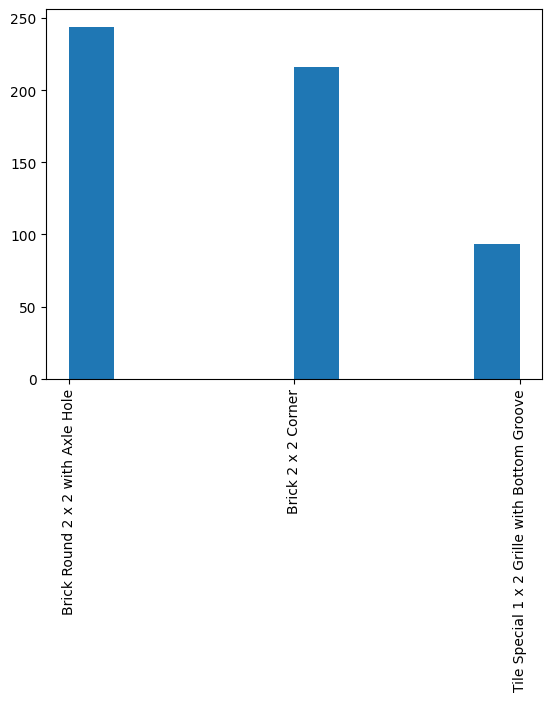

In [25]:
l = [l["label"] for l in ds_train.observations]
plt.xticks(rotation=90)
plt.hist(l)

torch.Size([1, 3, 64, 64])

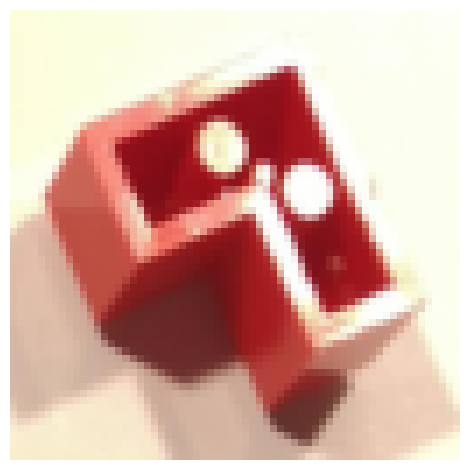

In [26]:
img = next(iter(dl_train))["image"]
img.shape
ts.show(img)

## Step 2 - Implement Baselines

In this step we want to implement a training pipeline and evaluate simple baselines to get a feeling for the problem and to test and verify if the pipeline works.

**Reproducibility**

- Fix random seed: Always use a fixed random seed to ensure consistent outcomes in repeated runs.

**Simplification and Initialization**

- Simplify: Disable unnecessary features like data augmentation initially.
- Verify loss at initialization: Ensure loss starts at the expected value.

**Baselines and Metrics**

- Human baseline: Compare model metrics to human-interpretable metrics (e.g., accuracy).
- Input-independent baseline: Train a baseline model with zeroed inputs and compare it to a variant with normal data. There should be a clear difference!

**Overfitting and Visualization**

- Overfit one batch: Overfit a single batch to verify the model can reach the minimum loss.
- Verify decreasing training loss: Ensure training loss decreases when model capacity increases.
- Visualize before the net: Visualize data immediately before feeding it to the network to catch preprocessing issues.
- Visualize prediction dynamics: Track model predictions on a fixed test batch during training to understand training progression.

**Evaluation**

- Add significant digits to your eval: Evaluate on the entire test set for accuracy.
- Visualize: Visualize model inputs and outputs to ensure correctness.

**Additional Tips**

- Verify simplifications: Simplify initial setup by turning off data augmentation and complex features to reduce bugs.

We will address some of the steps above. Feel free to do more!

### Reproducibility

The `lightning`package provides a function to set random seeds of different modules:

In [27]:
import lightning as L

L.seed_everything(123)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

### Simple DataLoader

Implement a simple dataloader without fancy transformations. To specify transformations, use [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html).

In [28]:
# Define a simple transformation
tr_train = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

ds_train = ImageFolder.from_subset(ds, train_ids, transform=tr_train)
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=3)

Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 553 images from the original dataset of 769 images


tensor(1.)

tensor(0.0196)

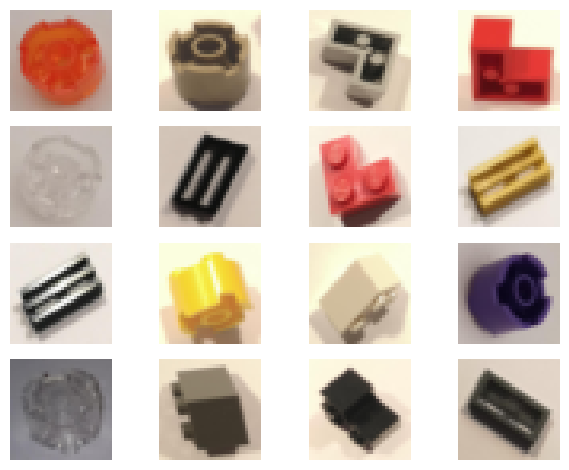

In [29]:
obs = next(iter(dl_train))
ts.show(obs["image"])
obs["image"].max()
obs["image"].min()

### Simple Model

Start with a simple model that is (most likely) correct and should be able to learn something (quickly).

For example you could implement the following architecture.

- Input Shape: (3, **height**, **width**)
- Convolution: 16 Filters, Kernel-Size 5x5
- Pooling: Stride 2, Kernel-Size 2
- Convolution: 32 Filter, Kernel-Size 5x5
- Global Average Pooling
- FC: 2 neurons (**number of classes**)

Use `ReLU` activation after each convolution.

Define a class which inherits from `torch.nn.Module`.


In [30]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, (5, 5))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 2)  # adapt to the number of classes here

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.fc(x)
        return x


net = SmallCNN()

print(net)
print(torchinfo.summary(net, input_size=(1, 3, 32, 32)))

SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 28, 28]           1,216
├─MaxPool2d: 1-2                         [1, 16, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 10, 10]           12,832
├─MaxPool2d: 1-4                         [1, 32, 5, 5]             --
├─AdaptiveAvgPool2d: 1-5                 [1, 32, 1, 1]             --
├─Linear: 1-6                            [1, 2]                    66
Total params: 14,114
Trainable params: 14,114
Non-trainable params: 0
Total mult-adds (Units.

### Define a training Loop

We use Lightning which greatly simplifys implementing boilerplate code such as  training loops.

Tutorial here: https://lightning.ai/pages/community/tutorial/step-by-step-walk-through-of-pytorch-lightning/

We also include additional metrics from [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/) to easily log and calculate accuracy.  Adapt `task="binary"` if necessary!

**Note**: Calculating the metrics incorrectly is a common source of errors. Make sure to correctly aggregate metrics across an epoch.

In [31]:
import torchmetrics


class Classifier(L.LightningModule):
    def __init__(self, model, num_classes=2, weight_decay: float = 0.0):
        super().__init__()
        self.model = model

        self.weight_decay = weight_decay

        self.loss_fn = nn.CrossEntropyLoss()

        # Accuracy
        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

        # Loss
        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update all metrics
        self.train_loss.update(loss)
        self.train_accuracy.update(preds, y)

        # Log metrics for bartch
        self.log("train/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)

        self.log(
            "train/acc_step",
            self.train_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_train_epoch_end(self):
        # Log average loss and metrics for the entire epoch
        avg_loss = self.train_loss.compute()
        avg_accuracy = self.train_accuracy.compute()

        self.log("train/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("train/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True)

        # Reset metrics for the next epoch
        self.train_loss.reset()
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update metrics
        self.val_loss.update(loss)
        self.val_accuracy.update(preds, y)

        # Log metrics for this batch
        self.log("val/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)
        self.log(
            "val/accuracy_step",
            self.val_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_validation_epoch_end(self):
        # Log average loss and metrics for the entire validation epoch
        avg_loss = self.val_loss.compute()
        avg_accuracy = self.val_accuracy.compute()

        self.log("val/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("val/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True)

        # Reset metrics for the next epoch
        self.val_loss.reset()
        self.val_accuracy.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), lr=0.001, weight_decay=self.weight_decay
        )

Change the following parameters accoring to your hardware if you need. As you can see, this simplifies hardware switches greatly!

We want to perform a functional check only. Train the model only for 10 steps.

**Question**: What is the loss at initialization / after 10 steps? Does the value make sense?

Now we train the model for longer to get a sense of the performance (increase the number of steps `max_steps` the model is training for).

In [28]:
#!pip install mlflow

In [30]:
from lightning.pytorch.loggers import MLFlowLogger

L.seed_everything(123)

max_epochs = 3
max_steps = 500

dev_run = False

# mlf_logger = MLFlowLogger(experiment_name="lightning_logs")
tb_logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="A1")

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=max_epochs,
    max_steps=max_steps,
    fast_dev_run=dev_run,
    enable_checkpointing=False,
    logger=tb_logger,
    log_every_n_steps=1,
    default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
)

net = SmallCNN()
model = Classifier(net)
trainer.fit(model, train_dataloaders=dl_train)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | model          | SmallCNN         | 14.1 K | train
1 | loss_fn        | CrossEntropyLoss | 0      | train
2 | train_accuracy | BinaryAccuracy   | 0      | train
3 | train_loss     | MeanMetric       | 0      | train
------------------------------------------------------------
14.1 K    Trainable params
0         Non-trainable params
14.1 K    Total params
0.056     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.cal

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [31]:
trainer.logged_metrics

{'train/acc_step': tensor(0.7500),
 'train/loss_step': tensor(0.3107),
 'train/acc_epoch': tensor(0.7143),
 'train/loss_epoch': tensor(0.5023)}

In [41]:
logdir = SCRIPT_DIR / "lightning_logs"
logdir = f"'{logdir}'"
%reload_ext tensorboard


print(f"Log dir: {logdir}\nserver on: http://127.0.0.1:6006")
%tensorboard --logdir={logdir} --host 127.0.0.1 --port=6006

Log dir: '/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/lightning_logs'
server on: http://127.0.0.1:6006


Reusing TensorBoard on port 6006 (pid 64209), started 0:17:49 ago. (Use '!kill 64209' to kill it.)

In [30]:
#!kill 3058

**Question**: What is your conclusion? Does learning take place?

## Learn Input independent Model


Modify the `Dataset` class such that random images, e.g. white noise, is returned. The label remains unchanged. Then train a model.

**Question**: What kind of loss do you expect for random image data?

In [34]:
from utils import ImageFolderRandom

# Create the dataset and dataloader
ds_train_random = ImageFolderRandom.from_subset(ds, train_ids, transform=tr_train)

# ds_train_random = ImageFolderRandom(ds_train)

dl_train_random = DataLoader(
    ds_train_random, batch_size=64, shuffle=True, num_workers=5
)

Found the following classes: ['Brick 2 x 2 Corner', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 429 images
Created a subset with 308 images from the original dataset of 429 images


Verify your work!

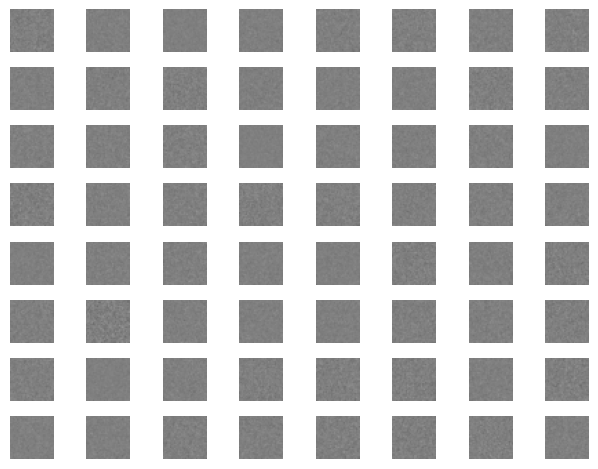

In [35]:
obs_random = next(iter(dl_train_random))
ts.show(obs_random["image"])

Now train your model.

In [37]:
L.seed_everything(123)

tb_logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="B1")
trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    fast_dev_run=False,
    max_steps=2,
    enable_checkpointing=False,
    logger=tb_logger,
    log_every_n_steps=1,
    default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
)

net = SmallCNN()
model = Classifier(net)
trainer.fit(model, train_dataloaders=dl_train_random)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | model          | SmallCNN         | 14.1 K | train
1 | loss_fn        | CrossEntropyLoss | 0      | train
2 | train_accuracy | BinaryAccuracy   | 0      | train
3 | train_loss     | MeanMetric       | 0      | train
------------------------------------------------------------
14.1 K    Trainable params
0         Non-trainable params
14.1 K    Total params
0.056     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.cal

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2` reached.


In [38]:
print(f"Metrics:  {trainer.logged_metrics}")

Metrics:  {'train/acc_step': tensor(0.7344), 'train/loss_step': tensor(0.6514), 'train/acc_epoch': tensor(0.7031), 'train/loss_epoch': tensor(0.6635)}


### Overfit on one Batch of Data

We train the model with only one batch. This means the model only ever sees the same `batch_size` number of images.

**Question**: What do you expect?

In [39]:
L.seed_everything(123)

tb_logger = (TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="B1"),)

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    fast_dev_run=False,
    max_steps=100,
    enable_checkpointing=False,
    logger=tb_logger,
    default_root_dir=DATA_PATH.joinpath("lightning_logs"),
    # this option limits the training set to one batch, disables shuffle
    overfit_batches=1,
)

net = SmallCNN()
model = Classifier(net)

dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=5)
trainer.fit(model, train_dataloaders=dl_train)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | model          | SmallCNN         | 14.1 K | train
1 | loss_fn        | CrossEntropyLoss | 0      | train
2 | train_accuracy | BinaryAccuracy   | 0      | train
3 | train_loss     | MeanMetric       | 0      | train
------------------------------------------------------------
14.1 K    Trainable params
0    

Training: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x112e41a80>
Traceback (most recent call last):
  File "/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/.env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/.env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Pyth

NameError: name 'exit' is not defined

In [ ]:
print(f"Metrics:  {trainer.logged_metrics}")

**Question**: Did it work?

## Step 3 - (Over)Fit

In this step we try to drive the trainings-loss as low as possible.

**Model Selection and Initialization**

- Pick a proven model: Start with a simple, well-established architecture (e.g., ResNet-50 for image classification) rather than creating complex, custom models.
- Use Adam optimizer: Begin with Adam and a learning rate of 3e-4 for its forgiving nature with hyperparameters (or the PyTorch default value).

**Gradual Complexity**

- Add complexity incrementally: Integrate multiple signals or features into your classifier one at a time, ensuring each addition improves performance.

**Learning Rate Management**

- Avoid default learning rate decay: Be cautious with repurposed code and learning rate decay schedules. Initially, disable learning rate decay and maintain a constant learning rate, tuning it later in the project.
    

You can do the following:
- implement your own model
- use a pre-defined model
- use a pre-trained model

**Important**: Inspect how the model performs. Which samples does it correctly classify? Which samples are wrong? Do you see a pattern? Can this be fixes?

### Setup

We load the data again and start from scratch.

In [32]:
from dl_cv_lectures import utils


ds = ImageFolder(DATA_PATH)

all_ids = [i for i in range(0, len(ds.observations))]
all_labels = [x["label"] for x in ds.observations]

train_ids, val_ids, test_ids = utils.create_train_test_split(
    all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
)


ds_train = ImageFolder.from_subset(ds, train_ids)
ds_val = ImageFolder.from_subset(ds, val_ids)
ds_test = ImageFolder.from_subset(ds, test_ids)

Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 553 images from the original dataset of 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 62 images from the original dataset of 769 images
Found the following classes: ['Brick 2 x 2 Corner', 'Brick Round 2 x 2 with Axle Hole', 'Tile Special 1 x 2 Grille with Bottom Groove'], in total 769 images
Created a subset with 154 images from the original dataset of 769 images


## Pre-Trained Model

In the following we will use a pre-trained model and adapt it to our dataset (transfer-learning).

### Load Model

Here we use a pre-trained model.  Read the doc here: [https://pytorch.org/vision/0.8/models.html](https://pytorch.org/vision/0.8/models.html).)

**It is important to read how the data is pre-processed for a given pre-trained model. This should be consistent with how you pre-process the data.**


In [33]:
import torchvision.models as models

net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

tr_train = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.RandomResizedCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

tr_val = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


print(torchinfo.summary(net, input_size=(1, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 64, 16, 16]           --
│    └─BasicBlock: 2-1                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           --
│

Now we adapt the output layer to match our dataset.

**Adapt** to the correct number of classes.

In [34]:
num_classes = len(ds.classes)
net.fc = nn.Sequential(nn.Linear(512, num_classes))

We can now train the model.

We also use a `logger` object to log the training process.

Again: Adjust the parameters of the trainer class to your liking.

In [38]:
from utils import DataSetModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

L.seed_everything(123)


logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="resnet18")


# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val/accuracy_epoch",
    min_delta=0.00,
    patience=3,
    mode="max",
    verbose=True,
    strict=True,
)

max_epochs = 2
max_steps = 100

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=max_epochs,
    max_steps=max_steps,
    fast_dev_run=False,
    enable_checkpointing=False,
    logger=logger,
    log_every_n_steps=1,
    default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
)

model = Classifier(net, num_classes=num_classes)


dm = DataSetModule(
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    classes=ds.classes,
    train_transform=tr_train,
    test_transform=tr_val,
    batch_size=64,
)


trainer.fit(model, datamodule=dm)

INFO: Seed set to 123
INFO:lightning.fabric.utilities.seed:Seed set to 123


123

INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | train_loss     | MeanMetric         | 0      | train
5 | val_loss       | MeanMetric         | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/.env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt/.env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [37]:
print(f"Metrics: {trainer.logged_metrics}")

Metrics: {'train/loss_step': tensor(0.4349), 'val/loss_step': tensor(31.0543), 'val/loss_epoch': tensor(31.0543), 'val/accuracy_epoch': tensor(0.5645), 'train/loss_epoch': tensor(0.3629), 'train/accuracy_epoch': tensor(0.8915)}


View the tensorboard logs. This may not work in a container without opening tensorboard ports.

(You would need to add the following options to docker run `-p 6006-6015:6006-6015`)

If working locally, you can simply type: `localhost:6008' in your browser, after executing he following lines.

**Task**: Feel Free to try a larger model and observe the performance. You also might want to train your model longer.

**Task**: It is important to insepct model performance at this point. Try to figure out where the model works well and where it fails. And try to figure out why and if you can do something about it.

## Step 4) - Regularization

Regularization is a process to deliberately limit a model's capacity in order to reduce overfitting and to improve generalization.

**Data Collection and Augmentation**

- Get more data: Collect additional real training data for the most effective regularization.
- Data augmentation: Use more aggressive data augmentation techniques.
- Creative augmentation: Explore simulation, hybrid methods, or GANs to expand datasets.

**Model Initialization and Size**

- Pretrain: Utilize pretrained networks when possible.
- Smaller input dimensionality: Remove features with spurious signals and reduce image size if low-level details are not critical.
- Smaller model size: Use domain knowledge to constrain and reduce the size of the network.

**Regularization Techniques**

- Decrease batch size: Smaller batch sizes can act as stronger regularizers due to batch normalization effects.
- Add dropout: Use dropout (including dropout2d for ConvNets) sparingly.
- Weight decay: Increase the weight decay penalty.
- Early stopping: Stop training based on validation loss to avoid overfitting.

**Model Complexity**

- Try a larger model: Consider larger models for potentially better early-stopped performance, despite higher risk of eventual overfitting.

  

You can try the following techniques:

- Weight Decay
- Data Augmentation
- Early Stopping on Validation Set


### Weight Decay

Weight decay is a technique to reduce model complexity by adding a penalty to the magnitude of the weights. It can be implemented by decaying the weights towards 0 after each gradient descent step.

Read the following documentation and add Weight Decay to your model: [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

It is implemented in the optimizer.

Make it configurable.

In [ ]:
class Classifier(L.LightningModule):
    def __init__(self, model, weight_decay: float = 0.0):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.weight_decay = weight_decay
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.train_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update accuracy metric
        self.train_accuracy(preds, y)
        self.train_loss(loss)

        self.log("train_acc_step", self.train_accuracy, prog_bar=True)
        self.log("train_loss_step", self.train_loss, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        # log epoch metric
        self.log("train_acc_epoch", self.train_accuracy)
        self.log("train_loss_epoch", self.train_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=self.weight_decay)

## Data Augmentation

Data augmentation is the process of applying random transformations to the input data before it is processed by the model. This increases the robustness of the model and improves its generalization capabilities.

**Note**: Always check if the data augmentations are plausible and not too extreme!

In [ ]:
tr_train = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.RandomResizedCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # values from model
    ]
)

tr_val = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

ds_train = ImageFolder.from_subset(ds, train_ids, transform=tr_train)

dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=5)

In [ ]:
obs = next(iter(dl_train))

ts.show(obs["image"])

**Question**: Does the data still look plausible?

In [ ]:
L.seed_everything(123)

logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="data_augmentation")

model = Classifier(net)
trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_steps=10,
    fast_dev_run=False,
    enable_checkpointing=False,
    logger=logger if not DEBUG else None,
    default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
)

trainer.fit(model, train_dataloaders=dl_train)

## Early Stopping

Early stopping monitors the training process on a separate validation set to determine the optimal point regarding when to stop training (when validation loss / metric is at the best level).

Pytorch-lightning provides such functionality out-of-the-box: [pytorch_lightning.callbacks.early_stopping.EarlyStopping](https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)

**Make sure to let the model run enough steps such that early stopping is actually stopping the training!**

Implement a metric which early stopping should monitor. It should be one calculated on the validation set.


    Inspect the `Trainer` class and set more appropriate values  (e.g. `val_check_interval` and `max_steps`)

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val/accuracy_epoch", min_delta=0.00, patience=3, mode="max", verbose=True
)

We use a more fully fledged class of a classifier lightning module.

In [ ]:
L.seed_everything(123)

from dl_cv_lectures import classifier

logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="early_stopping")

model = classifier.Classifier(net, num_classes=2)
trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=2,
    fast_dev_run=False,
    enable_checkpointing=False,
    logger=logger if not DEBUG else None,
    callbacks=[early_stopping],  # Add the early stopping callback here
    default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
)

dl_val = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=5)

trainer.fit(model, train_dataloaders=dl_train, val_dataloaders=dl_val)

**Question**: Compare training metrics with validation metrics. What do you observe?

# Step 5 - Hyper-Parameter Optimization

To optimize hyper parameters we need to consider the following:
- paramaterize training process (architecture and pre-processing)
- experiment tracking software
- evaluation procedures (such as cross-validation for smaller datasets)
- use specialized packages to track and run experiments in parallel


**Hyper-Parameter Tuning can be time consuming!** You might want to skip it for now.

Ideally one uses special libraries such as [RayTune](https://docs.ray.io/en/latest/tune/index.html).

We combine `RayTune` with `Lightning`. Here is the example we follow below: [Link](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-lightning.html)

We systematically test different data augmentation methods.

We use a `L.LightningDataModule` to parameterize and simplify data preparation, since data augmentation is defined on the dataset level.

## Setup

We setup all the necessary data.

In [ ]:
from dl_cv_lectures import utils
from dl_cv_lectures.data.image_folder import ImageFolder

image_root_path = DATA_PATH.joinpath("cats_vs_dogs/PetImages")

ds = ImageFolder(image_root_path)

all_ids = [i for i in range(0, len(ds.observations))]
all_labels = [x["label"] for x in ds.observations]

train_ids, val_ids, test_ids = utils.create_train_test_split(
    all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
)

ds_train = ImageFolder.from_subset(ds, train_ids)
ds_val = ImageFolder.from_subset(ds, val_ids)
ds_test = ImageFolder.from_subset(ds, test_ids)

## Define Parameter Grid

We need to define a `search_space` that specifies which hyper parameters to vary and how to sample from them.

In [ ]:
# Define the different augmentation strategies
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


test_transforms = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        norm,
    ]
)


simple_transforms = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ]
)

complex_transforms = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        norm,
    ]
)

wild_transforms = transforms.Compose(
    [
        transforms.v2.RGB(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        norm,
    ]
)

PRE_PROCESSING = {
    "test": test_transforms,
    "simple": simple_transforms,
    "complex": complex_transforms,
    "wild": wild_transforms,
}

In [ ]:
import ray

ray.init(configure_logging=False)

This is the search space we define. We only want to vary the data augmentation.

In [ ]:
from ray import tune

search_space = {
    "pre_processing": tune.grid_search(["simple", "complex", "wild"]),
    "batch_size": 32,
    "epochs": 2,
}

In [ ]:
dm = DataSetModule(
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    classes=["Cat", "Dog"],
    train_transform=complex_transforms,
    test_transform=test_transforms,
    batch_size=32,
)

In [ ]:
dm.setup("fit")

In [ ]:
dl_train = dm.train_dataloader()

In [ ]:
batch = next(iter(dl_train))

In [ ]:
batch["label"]

In [ ]:
dl_val = dm.val_dataloader()
batch = next(iter(dl_val))
batch["label"]

## Setup Ray Tuner Loop

Next we define a configurable `train_func` which creates a `lightning.Trainer` object with some additional `ray.tuner` magic.

In [ ]:
import torchvision.models as models
from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

from dl_cv_lectures import classifier
from dl_cv_lectures.data.image_folder import DataSetModule

NUM_CLASSES = 2


def train_func(config):
    dm = DataSetModule(
        ds_train=ds_train,
        ds_val=ds_val,
        ds_test=ds_test,
        classes=["Cat", "Dog"],
        train_transform=PRE_PROCESSING[config["pre_processing"]],
        test_transform=test_transforms,
        batch_size=config["batch_size"],
    )

    logger = TensorBoardLogger(SCRIPT_DIR.joinpath("lightning_logs"), name="ray_tune")

    net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    net.fc = nn.Sequential(nn.Linear(512, NUM_CLASSES))

    model = classifier.Classifier(net, num_classes=2)

    trainer = L.Trainer(
        devices="auto",
        accelerator="auto",
        precision="32",
        max_epochs=config["epochs"],
        fast_dev_run=False,
        enable_checkpointing=False,
        logger=logger if not DEBUG else None,
        # callbacks=[early_stopping],  # Add the early stopping callback here
        # default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
    )

    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

We can specify the hardware ressources that we want to invest in the tuning process.

In [ ]:
from ray.train import CheckpointConfig, RunConfig, ScalingConfig

scaling_config = ScalingConfig(
    num_workers=1, use_gpu=True, resources_per_worker={"CPU": 4, "GPU": 1}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=None,
        checkpoint_score_attribute="val/accuracy_epoch",
        checkpoint_score_order="max",
    ),
    storage_path=DATA_PATH.joinpath("lightning_logs/ray"),
    name="data_augmentation",
)

In [ ]:
from ray.train.torch import TorchTrainer

# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

We now define a scheduler, which is responible to select parameters for model training.

In this case we deliberately only have 3 different hyper-parameter options. But it could be much much more from which the scheduler must choose.

In [ ]:
from ray.tune.schedulers import ASHAScheduler


def tune_asha(num_samples=10):
    scheduler = ASHAScheduler(
        time_attr="training_iteration", max_t=1000, grace_period=100, reduction_factor=2
    )

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="val/accuracy_epoch",
            mode="max",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()


if not DEBUG:
    results = tune_asha(num_samples=1)

In [ ]:
if not DEBUG:
    results

# Step 6 - Squeeze out the Juice!

You can try the following techniques to get even further:

- advanced data augmentation. For example: https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
- model ensembling. Train multiple models and combine their predictions.
- advanced techniques: AdamW Optimizer, Stochastic Depth Regularization


**Task**: Try it out for yourself.

# 3) Evaluate your model

We may want to evaluate our model in more detail. In particular we want to know where the model works well and where it fails. This might give us additional insight in the data and the difficulties.

In [ ]:
from dl_cv_lectures import utils
from dl_cv_lectures.data.image_folder import ImageFolder

image_root_path = DATA_PATH.joinpath("cats_vs_dogs/PetImages")

ds = ImageFolder(image_root_path)

all_ids = [i for i in range(0, len(ds.observations))]
all_labels = [x["label"] for x in ds.observations]

train_ids, val_ids, test_ids = utils.create_train_test_split(
    all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
)

ds_train = ImageFolder.from_subset(ds, train_ids)
ds_val = ImageFolder.from_subset(ds, val_ids)
ds_test = ImageFolder.from_subset(ds, test_ids)


dm = DataSetModule(
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    classes=["Cat", "Dog"],
    train_transform=complex_transforms,
    test_transform=test_transforms,
    batch_size=32,
)

trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=2,
    fast_dev_run=False,
    enable_checkpointing=False,
    default_root_dir=SCRIPT_DIR.joinpath("lightning_logs"),
)

# trainer.test(model, dm)

### Confusion-Matrix

Plotten Sie eine _confusion matrix_. Benutzen Sie

- [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# fig, ax = plt.subplots(figsize=(8, 8))
# cm = confusion_matrix(y_true=true_all, y_pred=predicted_all)
# disp = ConfusionMatrixDisplay(cm, display_labels=classes)
# disp.plot(ax=ax, xticks_rotation='vertical')

**Question:** Which classes are confused how?